<a href="https://colab.research.google.com/github/Viraj465/Pytorch/blob/main/TorchComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

figuring out where different objects in an image can be separated *(panoptic segmentation).*

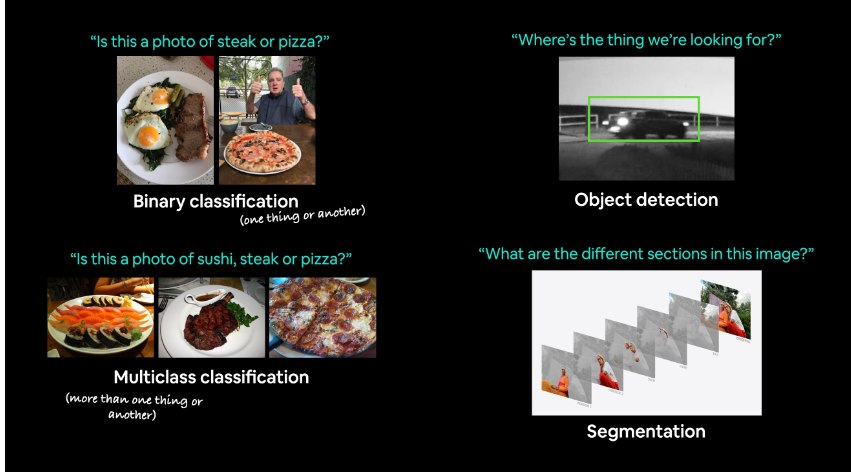


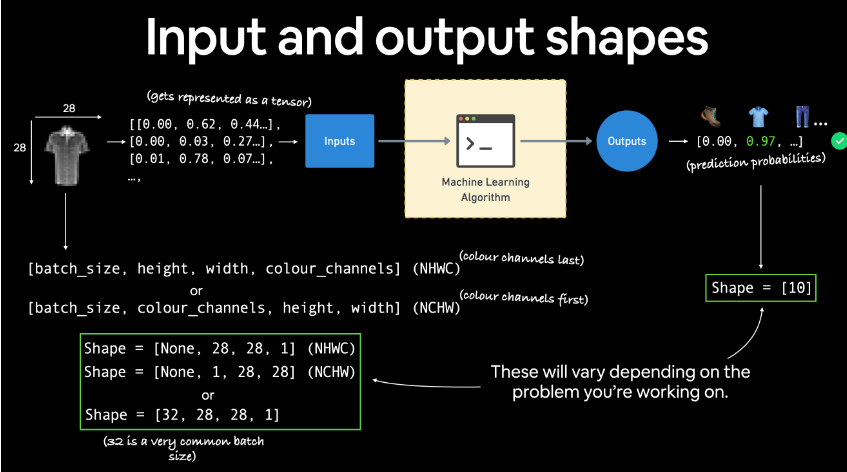

In [2]:
!pip install torchmetrics
!pip install torch-summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib inline
# import torch.utils.data.dataloader as DataLoader
import torchmetrics as metrics
from torchvision.datasets import ImageFolder
from torchsummary import summary
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


#Normal CV model

In [2]:
from torchvision.datasets import FashionMNIST

train_data = FashionMNIST(root="./data",
                          train = True,
                          download = True,
                          transform = ToTensor(), # images come as PIL format, we want to turn into Torch tensors
                          target_transform=None) # you can transform labels as well

test_data = FashionMNIST(root = './data',
                         train=False,
                         transform=ToTensor(),
                         download = True)


100%|██████████| 26421880/26421880 [00:00<00:00, 116577038.52it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5623972.50it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 63296045.14it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4674664.86it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
# 1st train eg
img, label = train_data[0]
img, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [7]:
img.shape #[color_channels=1, height=28, width=28]

torch.Size([1, 28, 28])

*Note: You'll also see NCHW and NHWC formats where N stands for number of images. For example if you have a batch_size=32, your tensor shape may be [32, 1, 28, 28]. We'll cover batch sizes later*

In [8]:
# How many samples are there?
len(train_data.data), len(train_data.targets),\
 len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [9]:
cls_names = train_data.classes
cls_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Text(0.5, 1.0, '9')

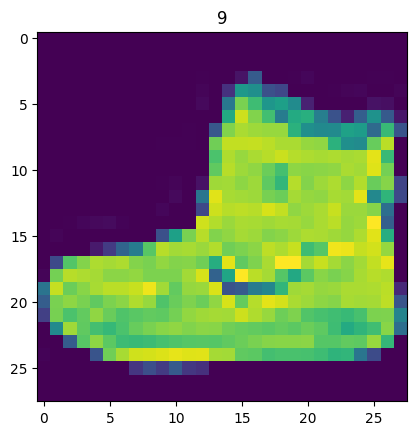

In [10]:
plt.imshow(img.squeeze())
plt.title(label)

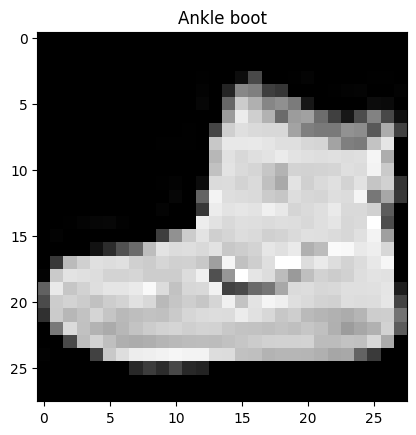

In [11]:
plt.imshow(img.squeeze(), cmap="gray")
plt.title(cls_names[label]);

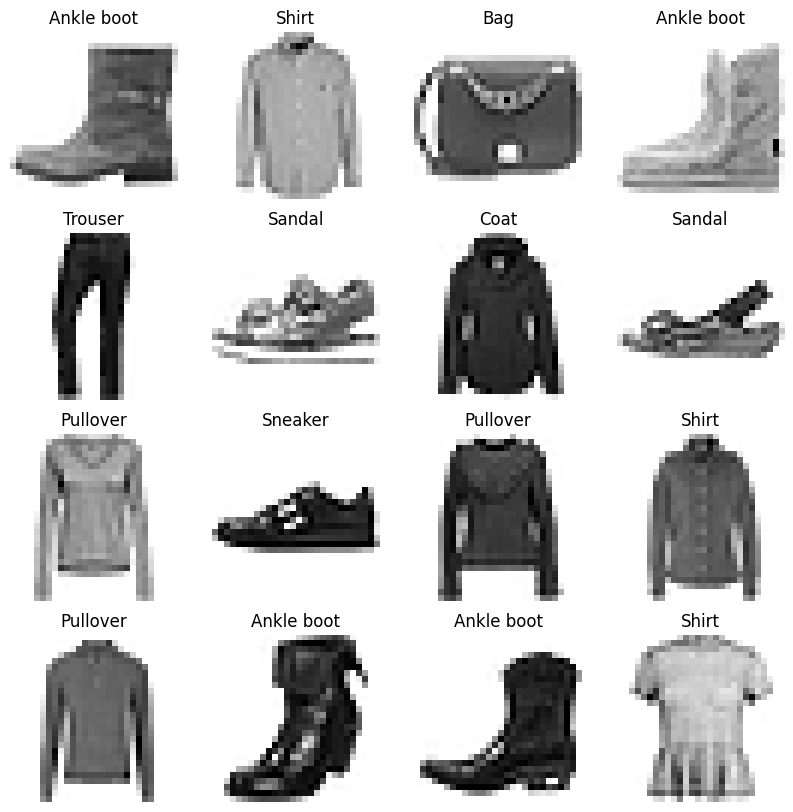

In [15]:
torch.manual_seed(42)
fig = plt.figure(figsize=(10,10))
r,c = 4,4
for i in range(1,r*c+1):
  rnd_idx = torch.randint(0,len(train_data),size=[1]).item()
  img,label = train_data[rnd_idx]
  fig.add_subplot(r,c,i)
  plt.imshow(img.squeeze(),cmap='gray_r')
  plt.title(cls_names[label])
  plt.axis("off")

In [17]:
# Dataloader uses to load data
from torch.utils.data import DataLoader
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False
                              )
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x78646488a3e0>, <torch.utils.data.dataloader.DataLoader object at 0x786464889240>)
Length of train dataloader: 938 batches of 64
Length of test dataloader: 157 batches of 64


In [18]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

Image size: torch.Size([1, 28, 28])
Label: 3, label size: torch.Size([])


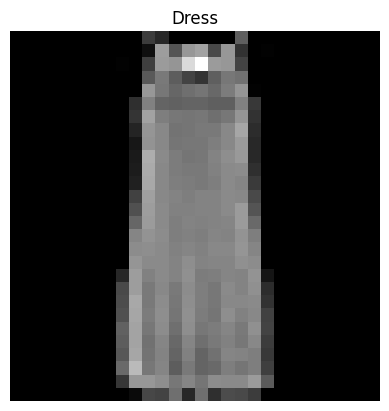

In [19]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(cls_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [20]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
print(x)
print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 

In [21]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [23]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(cls_names) # one for every class
)
model_0.to(device)

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [25]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [26]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [27]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = device):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [31]:
# Training

from tqdm.auto import tqdm
train_time_start_on_gpu = timer()
epochs = 100

for epoch in tqdm(range(epochs)):
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()
    #1. Formward pass
    y_pred = model_0(X.to(device))
    #2. Cal loss per batch
    loss = loss_fn(y_pred, y.to(device))
    train_loss += loss
    #3. Optimizer zero grad
    optimizer.zero_grad()
    #4. Loss backward
    loss.backward()
    #5. Optimizer step
    optimizer.step()

    # Print out how many samples have been seen
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train
  train_loss /=len(train_dataloader)
  # Testing
  test_loss,test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X,y in test_dataloader:
      #1. Forward Pass
      test_pred = model_0(X.to(device))
      # 2. Calculate loss (accumatively)
      test_loss += loss_fn(test_pred, y.to(device)) # accumulatively add up the loss per epoch
      # 3. Calculate acc (preds need to be same as y_true)
      test_acc += accuracy_fn(y_true=y.to(device), y_pred=test_pred.argmax(dim=1))

    # Divide total test loss by length of test
    test_loss /=len(test_dataloader)
    # Divide total accuracy by length of test dataloader (per batch)
    test_acc /=len(test_dataloader)

  print(f'\nTrain loss {train_loss:5f} | Test loss {test_loss:5f}, Test acc {test_acc:5f}')

train_time_end_on_gpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
                                           end=train_time_end_on_gpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/100 [00:00<?, ?it/s]

Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss 0.447174 | Test loss 0.469053, Test acc 83.091162
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss 0.435638 | Test loss 0.501779, Test acc 82.464172
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss 0.428073 | Test loss 0.483686, Test acc 83.160828
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss 0.424047 | Test loss 0.472611, Test acc 83.728105
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss 0.419371 | Test loss 0.459154, Test acc 83.748010
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss 0.413572 | Test loss 0.478084, Test acc 82.931927
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss 0.411445 | Tes

KeyboardInterrupt: 

In [33]:
def eval_model(model:torch.nn.Module,
               data_loader:DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
  """
  Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """

  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      y_pred = model(X.to(device)) #make preds

      loss+=loss_fn(y_pred,y.to(device)) #accumulate
      acc+=accuracy_fn(y_true=y.to(device), y_pred=y_pred.argmax(dim=1)) #acc

    # Scale loss and acc to find the average loss/acc per batch
    loss /=len(data_loader)
    acc /=len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4588826298713684,
 'model_acc': 83.88734076433121}

# Building a Convolutional Neural Network (CNN)

Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer

**Using Imagenette dataset with 10 classes**

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),  # Resize the images to 224x224
    torchvision.transforms.ToTensor(),  # Convert the images to PyTorch tensors
])

In [5]:
train_data = datasets.Imagenette(root = './data/imagenette2-160/train',
                                 download = True,
                                 transform=transform,
                                 target_transform=None)

test_data = datasets.Imagenette(root = './data/imagenette2-160/val',
                                download  = True,
                                transform = transform)


100%|██████████| 1557161267/1557161267 [00:39<00:00, 39113858.77it/s]


Extracting ./data/imagenette2-160/train/imagenette2.tgz to ./data/imagenette2-160/train


100%|██████████| 1557161267/1557161267 [00:51<00:00, 30451772.34it/s]


Extracting ./data/imagenette2-160/val/imagenette2.tgz to ./data/imagenette2-160/val


In [6]:
img, labels = train_data[2]
img

tensor([[[0.0706, 0.0980, 0.0784,  ..., 0.4039, 0.3686, 0.3294],
         [0.0902, 0.0667, 0.0431,  ..., 0.3608, 0.2784, 0.2627],
         [0.0941, 0.0784, 0.0431,  ..., 0.4784, 0.2941, 0.2314],
         ...,
         [0.3765, 0.2314, 0.2196,  ..., 0.5961, 0.6627, 0.6941],
         [0.3922, 0.2549, 0.2941,  ..., 0.5686, 0.6941, 0.6941],
         [0.4275, 0.3569, 0.4039,  ..., 0.4627, 0.6706, 0.6824]],

        [[0.2118, 0.2314, 0.2118,  ..., 0.5137, 0.4980, 0.4471],
         [0.2275, 0.1882, 0.1333,  ..., 0.4706, 0.4000, 0.3804],
         [0.2510, 0.1961, 0.1412,  ..., 0.6000, 0.4039, 0.3451],
         ...,
         [0.3490, 0.2549, 0.2314,  ..., 0.6510, 0.7176, 0.7412],
         [0.3490, 0.2706, 0.3294,  ..., 0.6196, 0.7569, 0.7490],
         [0.4667, 0.4510, 0.4471,  ..., 0.5098, 0.7451, 0.7490]],

        [[0.0314, 0.0392, 0.0392,  ..., 0.4471, 0.4078, 0.3647],
         [0.0314, 0.0353, 0.0431,  ..., 0.4157, 0.3216, 0.3098],
         [0.0549, 0.0471, 0.0275,  ..., 0.5725, 0.4196, 0.

In [7]:
img.shape

torch.Size([3, 224, 224])

In [8]:
cls_names = train_data.classes
cls_names

[('tench', 'Tinca tinca'),
 ('English springer', 'English springer spaniel'),
 ('cassette player',),
 ('chain saw', 'chainsaw'),
 ('church', 'church building'),
 ('French horn', 'horn'),
 ('garbage truck', 'dustcart'),
 ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 ('golf ball',),
 ('parachute', 'chute')]

TypeError                                 Traceback (most recent call last)
<ipython-input-9-51148ec20520> in <cell line: 1>()
----> 1 plt.imshow(img.squeeze())
      2 plt.title(label)

3 frames
/usr/local/lib/python3.10/dist-packages/matplotlib/image.py in set_data(self, A)
    708         if not (self._A.ndim == 2
    709                 or self._A.ndim == 3 and self._A.shape[-1] in [3, 4]):
--> 710             raise TypeError("Invalid shape {} for image data"
    711                             .format(self._A.shape))
    712

TypeError: Invalid shape (3, 224, 224) for image data

In [9]:
# converting to expected dims
img = torch.permute(img, (1,2,0))
img.shape

torch.Size([224, 224, 3])

Text(0.5, 1.0, '0')

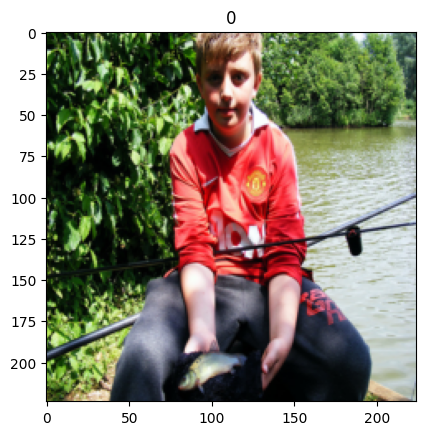

In [10]:
plt.imshow(img.squeeze())
plt.title(labels)

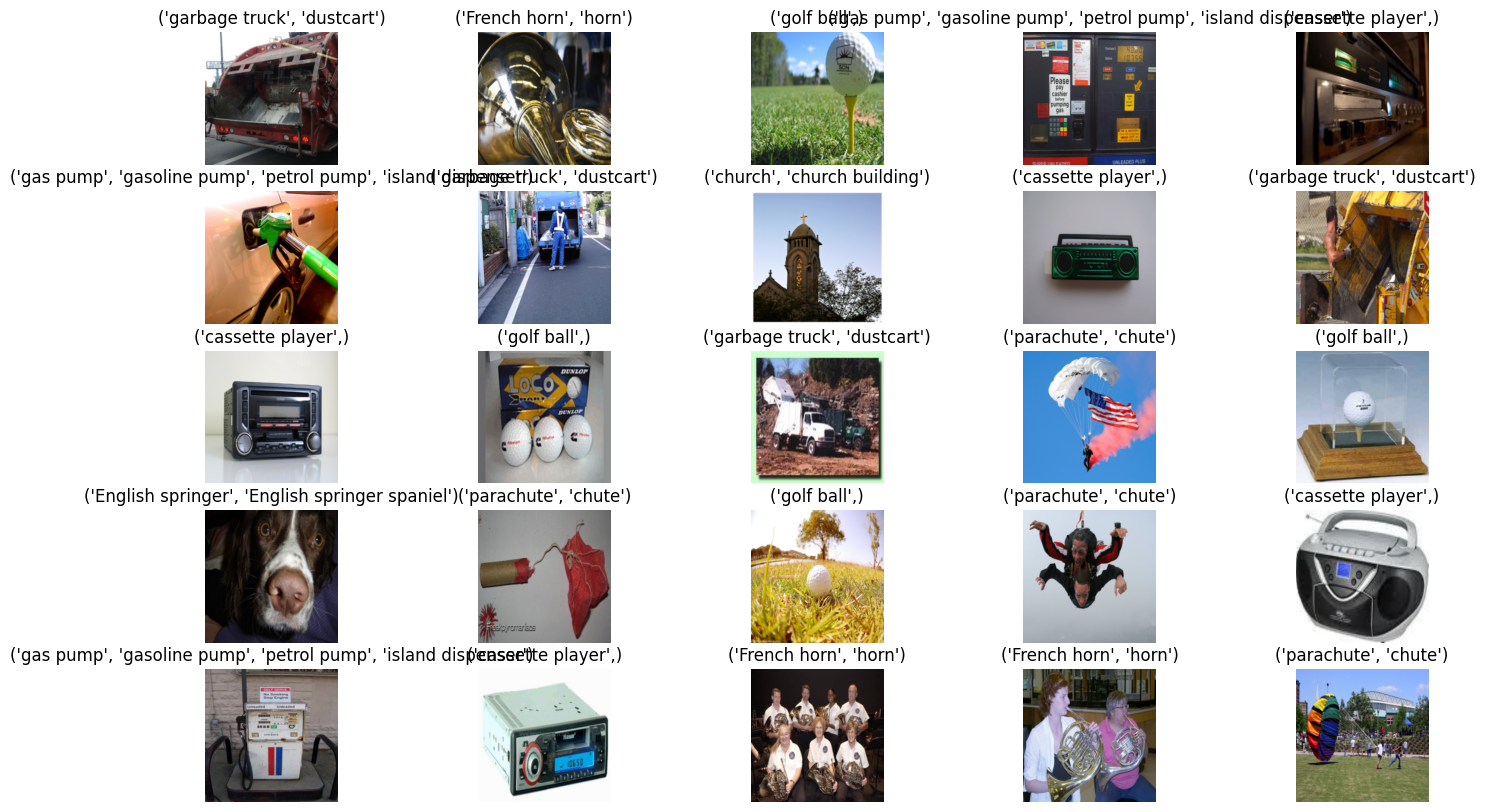

In [11]:
torch.manual_seed(42)
plt.figure(figsize=(17,10))
r,c = 5,5
for i in range(1,r*c+1):
  rnd_idx = torch.randint(0,len(train_data),size=[1]).item()
  img,label = train_data[rnd_idx]
  plt.subplot(r,c,i)
  plt.imshow(img.permute(1,2,0))
  plt.title(cls_names[label])
  plt.axis("off")

In [12]:
torch.manual_seed(42)
BATCH_SIZE = 64
train_dataloader = torch.utils.data.DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)
test_dataloader = torch.utils.data.DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                            shuffle = False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x78d6cd2b3d30>, <torch.utils.data.dataloader.DataLoader object at 0x78d6cad3f4f0>)
Length of train dataloader: 148 batches of 64
Length of test dataloader: 148 batches of 64


In [13]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

Image size: torch.Size([3, 224, 224])
Label: 1, label size: torch.Size([])


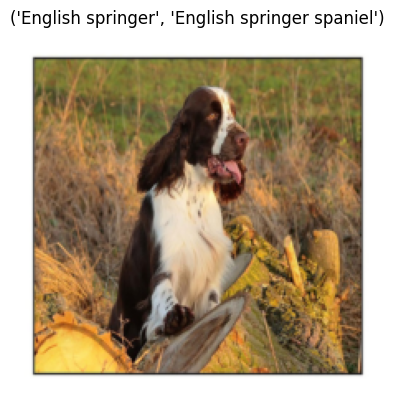

In [14]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.permute(1,2,0))
plt.title(cls_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'



* in_channels (int) - Number of channels in the input image.

out_channels (int) - Number of channels produced by the convolution.

kernel_size (int or tuple) - Size of the convolving kernel/filter.

stride (int or tuple, optional) - How big of a step the convolving kernel takes at a time. Default: 1.

padding (int, tuple, str) - Padding added to all four sides of input. Default: 0.



In [52]:
# Create a convolutional neural network
'''padding not supported for strided conv'''
class ImagenetteDataV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=2,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=2,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)  # Adjust this line
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(f"Shape after block 1: {x.shape}")
        x = self.block_2(x)
        # print(f"Shape after block 2: {x.shape}")
        x = self.block_3(x)
        # print(f"Shape after block 3: {x.shape}")
        x = self.classifier(x)
        # print(f"Shape after classifier: {x.shape}")
        return x

torch.manual_seed(42)
model_2 = ImagenetteDataV1(input_shape=3,
    hidden_units=64,
    output_shape=len(cls_names)).to(device)
# model_2

In [53]:
input_shape = (3, 224, 224)
torch.manual_seed(42)
example_input = torch.rand(1, *input_shape).to('cuda')
model_2(example_input)

tensor([[-0.0066, -0.0028, -0.0106, -0.0394, -0.0247,  0.0045,  0.0086, -0.0306,
         -0.0055, -0.0072]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [54]:
from torchsummary import summary
summary(model_2, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-6                       36,928
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       36,928
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-11                      36,928
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      36,928
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      36,928
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
├─Sequential: 1-4                        --


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-6                       36,928
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       36,928
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-11                      36,928
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      36,928
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      36,928
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
├─Sequential: 1-4                        --


# Toy data

In [34]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [35]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here

# Pass the data through the convolutional layer
conv_layer(test_image) # Note: If running PyTorch <1.11.0, this will error because of shape issues (nn.Conv.2d() expects a 4d tensor as input)

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

In [36]:
# Add extra dimension to test image
test_image.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [37]:
# Pass test image with extra dimension through conv_layer
conv_layer(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 62, 62])

In [38]:
torch.manual_seed(42)
# Create a new conv_layer with different values (try setting these to whatever you like)
conv_layer_2 = nn.Conv2d(in_channels=3, # same number of color channels as our input image
                         out_channels=10,
                         kernel_size=(5, 5), # kernel is usually a square so a tuple also works
                         stride=2,
                         padding=0)

# Pass single image through new conv_layer_2 (this calls nn.Conv2d()'s forward() method on the input)
conv_layer_2(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 30, 30])

In [39]:
# Check out the conv_layer_2 internal parameters
print(conv_layer_2.state_dict())

OrderedDict([('weight', tensor([[[[ 0.0883,  0.0958, -0.0271,  0.1061, -0.0253],
          [ 0.0233, -0.0562,  0.0678,  0.1018, -0.0847],
          [ 0.1004,  0.0216,  0.0853,  0.0156,  0.0557],
          [-0.0163,  0.0890,  0.0171, -0.0539,  0.0294],
          [-0.0532, -0.0135, -0.0469,  0.0766, -0.0911]],

         [[-0.0532, -0.0326, -0.0694,  0.0109, -0.1140],
          [ 0.1043, -0.0981,  0.0891,  0.0192, -0.0375],
          [ 0.0714,  0.0180,  0.0933,  0.0126, -0.0364],
          [ 0.0310, -0.0313,  0.0486,  0.1031,  0.0667],
          [-0.0505,  0.0667,  0.0207,  0.0586, -0.0704]],

         [[-0.1143, -0.0446, -0.0886,  0.0947,  0.0333],
          [ 0.0478,  0.0365, -0.0020,  0.0904, -0.0820],
          [ 0.0073, -0.0788,  0.0356, -0.0398,  0.0354],
          [-0.0241,  0.0958, -0.0684, -0.0689, -0.0689],
          [ 0.1039,  0.0385,  0.1111, -0.0953, -0.1145]]],


        [[[-0.0903, -0.0777,  0.0468,  0.0413,  0.0959],
          [-0.0596, -0.0787,  0.0613, -0.0467,  0.0701],

In [40]:
# Get shapes of weight and bias tensors within conv_layer_2
print(f"conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]")

conv_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

conv_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


In [41]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [42]:
torch.manual_seed(42)
# Create a random tensor with a similiar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


# ENtering again in CNN

In [25]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [20]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.003)
loss_fn, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.003
     maximize: False
     weight_decay: 0
 ))

In [55]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [56]:
torch.manual_seed(42)

from tqdm.auto import tqdm
from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 100
for epoch in tqdm(range(epochs)):
  print(f'{epoch}-----------------------')
  train_step(data_loader = train_dataloader,
             model = model_2,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             optimizer = optimizer,
             device = device)
  test_step(data_loader = test_dataloader,
            model = model_2,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device = device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

0-----------------------
Train loss: 2.30231 | Train accuracy: 10.15%
Test loss: 2.30231 | Test accuracy: 10.15%

1-----------------------
Train loss: 2.30231 | Train accuracy: 10.15%
Test loss: 2.30231 | Test accuracy: 10.15%

2-----------------------
Train loss: 2.30231 | Train accuracy: 10.15%


KeyboardInterrupt: 